In [1]:
!pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN


In [8]:
# Load the dataset
data = pd.read_csv('/content/fetal_health.csv')

# Display the first few rows of the dataset
data.head()


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64


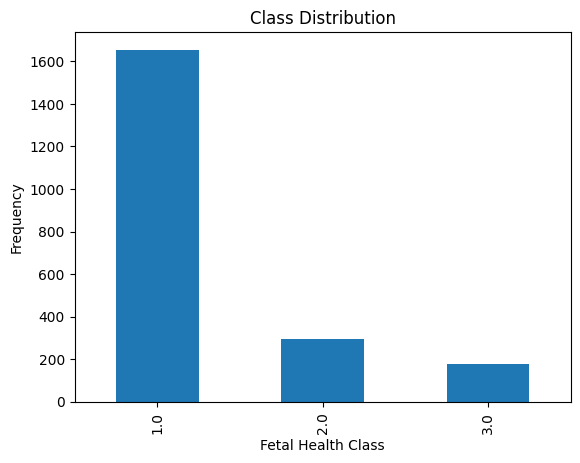

In [9]:
# Check class distribution
class_counts = data['fetal_health'].value_counts()
print(class_counts)

# Plotting class distribution
class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Fetal Health Class')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Define features and target variable
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']


In [11]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


fetal_health
3.0    1334
1.0    1323
2.0    1278
Name: count, dtype: int64


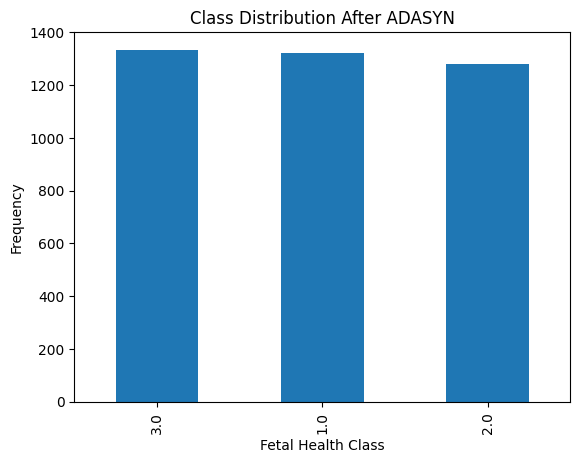

In [12]:
# Initialize ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Display new class distribution after resampling
new_class_counts = pd.Series(y_resampled).value_counts()
print(new_class_counts)

# Plotting new class distribution
new_class_counts.plot(kind='bar', title='Class Distribution After ADASYN')
plt.xlabel('Fetal Health Class')
plt.ylabel('Frequency')
plt.show()


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train a Random Forest classifier on the resampled data
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       332
         2.0       0.76      0.76      0.76        59
         3.0       0.89      0.89      0.89        35

    accuracy                           0.93       426
   macro avg       0.87      0.87      0.87       426
weighted avg       0.93      0.93      0.93       426



In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming X_resampled and y_resampled are your balanced datasets from ADASYN
# Split into training and test sets again if necessary
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.99      0.98      0.98       273
         2.0       0.98      0.99      0.98       245
         3.0       1.00      1.00      1.00       269

    accuracy                           0.99       787
   macro avg       0.99      0.99      0.99       787
weighted avg       0.99      0.99      0.99       787



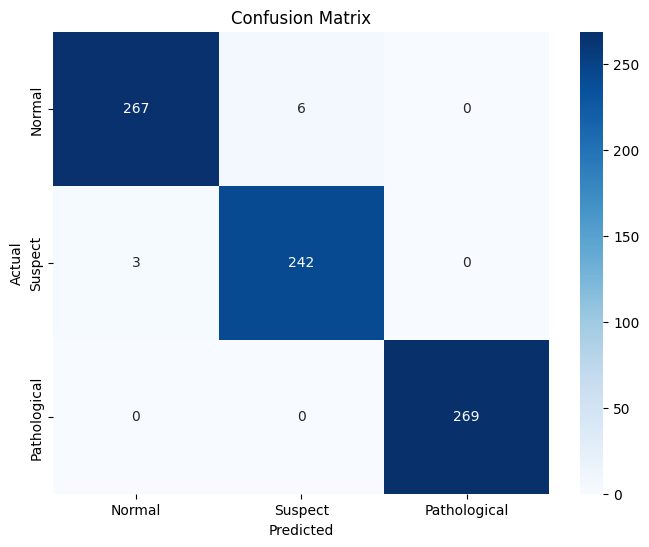

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Suspect', 'Pathological'], yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


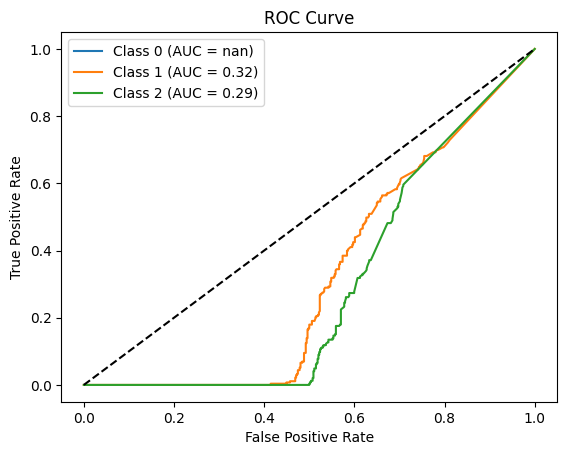

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_prob = best_model.predict_proba(X_test)

# Calculate ROC AUC for each class
for i in range(3):  # Assuming three classes (0, 1, 2)
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    auc = roc_auc_score(y_test == i, y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5)  # Use your balanced dataset
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


Cross-Validation Scores: [0.91740788 0.9707751  0.98348158 0.97331639 0.98348158]
Mean CV Score: 0.97
